<a href="https://colab.research.google.com/github/tombackert/paper/blob/main/explanation_selectivity_gradcam_and_lime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

!pip install torch torchvision torcheval matplotlib captum scikit-learn scikit-image

In [1]:
from typing import List, Literal, Iterable, Callable, Tuple, Optional

import torchvision as tv
from torchvision import models
from torch.nn import functional as F
from torchvision.tv_tensors import Image, TVTensor
import torchvision.transforms.v2.functional as transforms
from torch.masked import masked_tensor
import torcheval.metrics
import torch
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap ## for attribution visualization

from skimage.segmentation import felzenszwalb ## for LIME segmentation

import captum.attr
from captum.attr import LRP, Lime, LayerGradCam
from captum._utils.models.linear_model import SkLearnLinearModel
from captum.attr import visualization as viz

/Users/gesina/Postdoc/Nextcloud/teaching/2024-seminar-xai/explanation-selectivity/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## DEFINE model and data preprocessing

def my_model_from(model: torch.nn.Module):
    """Create wrapper around model."""
    def my_model(img: Image) -> List[float]:
        """Black-box wrapper of the model: redefine according to whatever model you are using.
        Just takes an image and returns a list of scores, one per class index in categories from above.
        """
        prediction = model(img) \
            .squeeze(0) \
            .softmax(0)
        return [t.item() for t in prediction]
    return my_model

def get_predicted_class_id(prediction: List[float]) -> int:
    """Get the ID of the predicted class from a list of per-class predicted probabilities or logits."""
    return int(np.argmax(prediction))


In [3]:
## DEFINE the explainer (here: e.g., LRP)

NUM_POSTERS = 40

def posterize(img: torch.Tensor, steps: int = NUM_POSTERS, method: Literal["min", "mean", "max", "maxabs"] = "mean"):
    """Reduce the amount of values used for a heatmap to at most steps number of values used.
    Existing values are binned, and each bin is assigned a common value.
    The value is determined according to method as either the min, max, mean of the bin, or the value which has maximum absolute.
    The ith cutoff point between values of the ith and (i+1)th bin is the (i/steps) quantile.
    This leads to mostly uniform sized bins, but with non-uniform distribution of the bins' assigned values.
    """
    img_detach = img.clone().detach()
    if method == "mean":
        to_poster_val = lambda mask: ((img_detach * mask).sum()/mask.sum()).nan_to_num(0)
    elif method == "min":
        to_poster_val = lambda mask: torch.where(mask, img_detach, torch.inf).min()
    elif method == "max":
        to_poster_val = lambda mask: torch.where(mask, img_detach, -torch.inf).max()
    elif method == "maxabs":
        to_poster_val = lambda mask: img_detach.flatten()[torch.where(mask, img_detach.abs(), -torch.inf).argmax()]
    else:
        raise ValueError(f"Got unsupported method for obtaining the poster values (supported: 'min', 'max', 'mean', 'maxabs'): {method=}")

    quantiles = [-torch.inf] + [torch.quantile(img_detach, (i+1)/steps) for i in range(steps-1)] + [torch.inf]
    poster_masks = torch.stack([(quantiles[i] <= img_detach) * (img_detach < quantiles[i+1]) for i in range(steps)])
    poster_values = torch.tensor([to_poster_val(poster_mask) for poster_mask in poster_masks])
    posters = poster_masks * poster_values.reshape(-1, *([1]*(len(poster_masks.size())-1)))
    return torch.sum(posters, dim=0)

def to_normalized_attr(explanation, target_size: Tuple[int, int] = None, outlier_percentage = 2):
    """(Sum and then) normalize values of (3- resp.) 2-channel heatmap to values between -1 and 1,
    treating outlier_percentage percent of the highest absolute values as outliers that are clamped to -1 resp. 1.

    :param: explanation: 3D or 2D attribution tensor.
    :param: outlier_percentage: percent of samples with highest absolute value to be treated as outliers. Set to 0, None or False to deactivate.
    """
    # Make 2D
    pp_explanation_unnormed = explanation if explanation.dim() == 2 else torch.sum(explanation, axis=0) # dim = WxH

    # Rescale
    if target_size and tuple(pp_explanation_unnormed.size()) != target_size:
        pp_explanation_unnormed = F.interpolate(
            pp_explanation_unnormed.view(1,1, *pp_explanation_unnormed.size()), # dim = 1x1xWxH
            size=target_size, 
            mode='bilinear', align_corners=True, antialias='bilinear'
            ).squeeze().squeeze() ## 2D WxH again

    # Remove outliers
    if outlier_percentage:
        expl_abs_max = torch.quantile(pp_explanation_unnormed.abs(), 1-outlier_percentage/100).item()
    else:
        expl_abs_max = pp_explanation_unnormed.abs().max().item()
    pp_explanation = torch.clamp(pp_explanation_unnormed/expl_abs_max, -1, 1)

    ## Inspect the distribution of explanation values
    #plt.hist(pp_explanation_unnormed.flatten().detach().numpy(), bins=1000)
    #plt.show()
    #plt.hist(pp_explanation.flatten().detach().numpy(), bins=1000)

    return pp_explanation

## E.g., my_explainer_from(LRP(model))
def my_explainer_from(explainer: captum.attr.Attribution, max_heatmap_features: int = NUM_POSTERS, to_feature_mask: Optional[Callable[[TVTensor], torch.Tensor]] = None):
    """Create wrapper around captum attribution explainer.
    
    :param: to_feature_mask: function that is called upon preproc_img to create a feature_mask as argument to explainer.attribute(). Can be overwritten during inference using kwargs.
    """
    def my_explainer(preproc_img: Image, model: Callable[[torch.Tensor], Iterable[float]], target_class_id=None, **kwargs):
        ## get model's prediction
        if target_class_id is None:
            prediction = model(preproc_img)
            target_class_id = get_predicted_class_id(prediction)
        if to_feature_mask is not None and "feature_mask" not in kwargs.keys():
            kwargs["feature_mask"] = to_feature_mask(preproc_img)

        ## get explanation heatmap
        img_size = preproc_img.size()[-2:]
        raw_explanation = explainer.attribute(preproc_img, target=target_class_id, **kwargs).squeeze(0) ## 3D CxWxH or 2D WxH, unscaled, non-normalized
        pp_explanation = to_normalized_attr(raw_explanation, target_size=img_size) ## 2D, scaled, normalized
        pp_explanation_posterized = posterize(pp_explanation, steps=max_heatmap_features) ## 2D, normalized and posterized
        return pp_explanation_posterized
    return my_explainer

In [4]:
## HELPER FUNCTIONS for plotting
def normalize_img(img: torch.Tensor, min_val: float = None, max_val: float = None):
    """Normalize values of tensor img to be in interval [0,1]."""
    min_val, max_val = min_val or img.min(), max_val or img.max()
    return (img - min_val) / (max_val-min_val)

def to_plottable(img: Image, force3d: bool = False) -> np.array:
    """Convert a tensor image (also from size-1 batch) or mask into a numpy array plottable with plt.imshow(<img_np>)."""
    if img.dim() == 4:
        img = img.squeeze(0)
    if img.dim() == 3:
        img = img.permute(1, 2, 0)
    if force3d and img.dim() == 2:
        img = img.unsqueeze(2)
    return img.cpu().detach().numpy()

cmap = LinearSegmentedColormap.from_list("RdWhGn", ["red", "white", "green"]) ## use the same one as captum to make comparable
def plot_attr(pp_explanation: torch.Tensor, cmap=cmap):
    """Plot a 2D or 3D normalized attribution heatmap (values in [-1,1]) using the specified cmap."""
    plt.imshow(to_plottable(pp_explanation), cmap=cmap, vmin=-1, vmax=1)

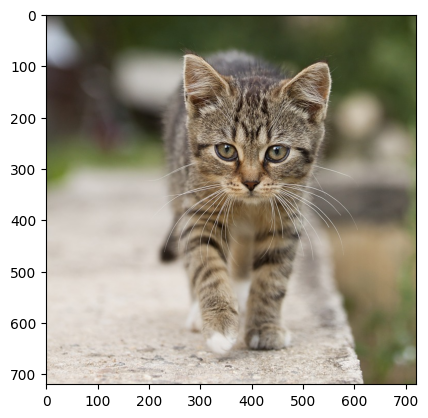

In [5]:
## PLAYGROUND: have a look at an example image
img: TVTensor = tv.io.read_image("kitten.jpg")
plt.imshow(to_plottable(img));

In [ ]:
## PLAYGROUND to explore the model prediction.

## Define the model
#weights = models.ResNet50_Weights.DEFAULT
weights = models.AlexNet_Weights.DEFAULT
#model: torch.nn.Module = models.resnet50(weights=weights).eval()
model: torch.nn.Module = models.alexnet(weights=weights).eval()
data_preproc = weights.transforms() ## model-specific data preprocessing function
categories = weights.meta["categories"] ## names of output classes; here: ImageNet classes
my_model = my_model_from(model)

preproc_img: TVTensor = data_preproc(img).unsqueeze(0)
prediction = my_model(preproc_img)

predicted_class_id = get_predicted_class_id(prediction)
predicted_class = categories[predicted_class_id]
predicted_class, predicted_class_id

def show_probs(pred: List[float], categories: List[str] = categories):
    #score_per_class = zip([categories, pred_vals])
    plt.xticks(rotation='vertical')
    plt.bar(x=categories, height=pred)

# Get and show the predicted probabilities for the 10 best classes:
quantile = np.quantile(prediction, 0.99)
preds, cats = zip(*[(pred, categories[i]) for i, pred in enumerate(prediction) if pred > quantile])
show_probs(preds, cats)

In [ ]:
## Playground: Inspect the LRP outputs (they produce scores per pixel per channel, not only per pixel)
explainer = LRP(model)
explanation = explainer.attribute(preproc_img, target=predicted_class_id).squeeze(0)
_ = viz.visualize_image_attr_multiple(to_plottable(explanation),
                                      to_plottable(img),
                                      ["original_image", "heat_map"],
                                      ["all", "all"],
                                      show_colorbar=True,
                                      outlier_perc=2)
## compare to the reduction to per-pixel scores:
plot_attr(to_normalized_attr(explanation))

## Now have a look at the posterized LRP outputs:
## first posterize, then normalize
explanation_posterized = posterize(explanation)
_ = viz.visualize_image_attr_multiple(to_plottable(explanation_posterized),
                                      to_plottable(img),
                                      ["original_image", "heat_map"],
                                      ["all", "all"],
                                      show_colorbar=True,
                                      outlier_perc=2)
## first normalize, then posterize:
pp_explanation_posterized = posterize(to_normalized_attr(explanation), steps=15)
print("unique (norm->poster):", pp_explanation_posterized.unique())
plot_attr(pp_explanation_posterized)
plt.show()

In [6]:
## COLLECT the results (for one image)

def collect_class_predictions_under_masking(preproc_img: torch.Tensor, my_model, my_explainer, categories=None, plot = False, **attr_kwargs):

    ## Get the target class ID
    clean_prediction = my_model(preproc_img)
    target_class_id = get_predicted_class_id(clean_prediction)

    ## Get explanation for the class
    pp_explanation_posterized = my_explainer(preproc_img, model=my_model, target_class_id=target_class_id, **attr_kwargs)
    if plot:
        plt.title("Explanation (red=-, green=+)")
        plot_attr(pp_explanation_posterized)
        plt.show()
    ## Assume this only has few used values (e.g., is posterized or uses super-pixels);
    ## define each the set of pixels belonging to the same value as (maskable) feature.
    values, indices = torch.unique(pp_explanation_posterized, return_inverse=True)
    if plot:
        plt.title("Values per bin after posterization")
        plt.bar(range(len(values)), height=values)
        plt.show()

    ## Collect the decreasing class predictions when masking
    results = []
    for i in range(len(values), 0, -1):
        ## Masking magic :-)
        masked_img = preproc_img - preproc_img*(indices.unsqueeze(0)>=i)
        prediction = my_model(masked_img)
        target_class_prediction = prediction[target_class_id]
        best_class_id = np.argmax(prediction) ## collected out of interest

        ## How does the masked image look like after masking the n most important features?
        if plot:
            to_plot = to_plottable(normalize_img(masked_img))
            print(to_plot.shape)
            plt.title(f'{len(values)-i} features rem. ({target_class_prediction:.2e}, "{best_class_id if categories is None else categories[best_class_id]}")')
            plt.imshow(to_plot)
            plt.show()

        results.append((
            prediction, # tensor of prediction scores
            target_class_prediction, # value of target class prediction score
            len(values)-i, # count of removed features
            best_class_id,
            masked_img
        ))

    return dict(zip([
        "predictions",
        "class_predictions",
        "nums_features_removed",
        "best_classes",
        "masked_imgs",
    ], zip(*results)))


def plot_results(results: dict, ncols: Optional[int] = 10, categories = None):
    """Plot the masks from the results from collect_class_predictions_under_masking in a grid of width ncols.
    If ncols is set to None or 0, only one row is plotted.
    If ncols is >0, the grid is filled left to right, top to bottom.
    """
    ## For consistent normalization: get global min and max value for this image series
    min_value, max_value = torch.concat(results["masked_imgs"]).min(), torch.concat(results["masked_imgs"]).max()

    results_zipped = list(zip(*results.values()))

    ## number of rows and columns
    num_imgs = len(results_zipped)
    nrows = 1 if not ncols else int(np.ceil(num_imgs/ncols))
    ncols = min(ncols, num_imgs) or num_imgs
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 5*nrows),
                            sharex=True, sharey=True, squeeze=False)
    for nrow, row in enumerate(axes):
        for ncol, ax in enumerate(row):
            idx = nrow*ncols + ncol
            if idx < num_imgs:
                _, pred, num_feat_rem, best_cls_id, masked_img = results_zipped[idx]
                to_plot = to_plottable(normalize_img(masked_img, min_val=min_value, max_val=max_value))
                ax.set_title(f'{num_feat_rem} features rem. ({pred:.2e}, "{best_cls_id if categories is None else categories[best_cls_id]}")')
                ax.imshow(to_plot)
    plt.show()
    return fig


def calc_auc(results: dict, plot: bool = False) -> float:
    """Calculate (and optionally plot) the area under curve for the given results."""
    ## Evaluate the results
    metric = torcheval.metrics.AUC()
    metric.update(torch.tensor(results["nums_features_removed"]), torch.tensor(results["class_predictions"]))
    auc = metric.compute().item()

    ## Show the plot how the class probability decreases with increasing masking steps
    if plot:
        plt.title(f"AUC: {auc:.5}")
        plt.plot(results["nums_features_removed"], results["class_predictions"])
    
    return auc
    

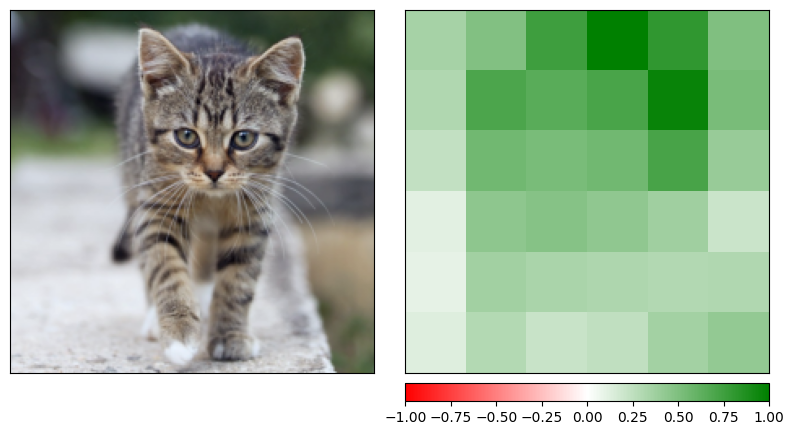

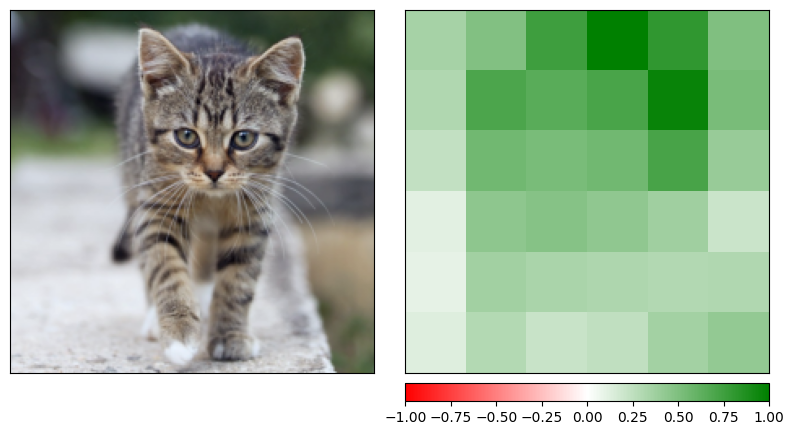

unique (norm->poster): tensor([0.1154, 0.2189, 0.2494, 0.3081, 0.3174, 0.3507, 0.3727, 0.4191, 0.4459,
        0.4970, 0.5292, 0.5653, 0.6995, 0.7512, 0.9391])
torch.Size([6, 6])


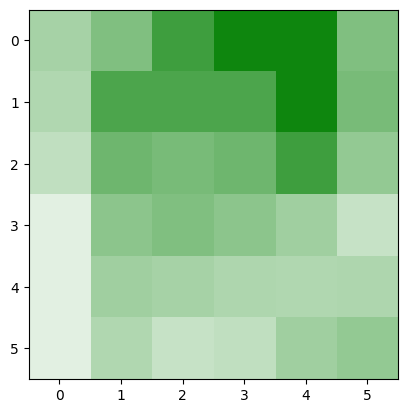

In [7]:
## Playground: Inspect the GradCAM outputs
weights = models.AlexNet_Weights.DEFAULT
model: torch.nn.Module = models.alexnet(weights=weights).eval()
data_preproc = weights.transforms() ## model-specific data preprocessing function
categories = weights.meta["categories"] ## names of output classes; here: ImageNet classes
my_model = my_model_from(model)

downscaled_img: torch.Tensor = F.interpolate(img.unsqueeze(0), size=(224, 224), mode='bilinear', antialias=True).squeeze(0)
preproc_img: TVTensor = data_preproc(img).unsqueeze(0)
prediction = my_model(preproc_img)
predicted_class_id = get_predicted_class_id(prediction)

gradcam_layer = model.features[-1] ## Adjust to the correct layer in the model
gradcam_explainer = LayerGradCam(model, gradcam_layer)
my_gradcam_explainer = my_explainer_from(gradcam_explainer)

gradcam_explanation = gradcam_explainer.attribute(preproc_img, target=predicted_class_id).squeeze(0)
_ = viz.visualize_image_attr_multiple(to_plottable(gradcam_explanation, force3d=True),
                                      to_plottable(normalize_img(preproc_img), force3d=True),
                                      ["original_image", "heat_map"],
                                      ["all", "all"],
                                      show_colorbar=True,
                                      outlier_perc=2)

## Now have a look at the posterized GradCAM outputs:
## first posterize, then normalize
gradcam_explanation_posterized = posterize(gradcam_explanation)
#gradcam_explanation_posterized = my_gradcam_explainer(preproc_img, model=my_model, target_class_id=predicted_class_id)
_ = viz.visualize_image_attr_multiple(to_plottable(gradcam_explanation_posterized, force3d=True),
                                      to_plottable(normalize_img(preproc_img), force3d=True),
                                      ["original_image", "heat_map"],
                                      ["all", "all"],
                                      show_colorbar=True,
                                      outlier_perc=2)
## first normalize, then posterize:
pp_gradcam_explanation_posterized = posterize(to_normalized_attr(gradcam_explanation), steps=15)
print("unique (norm->poster):", pp_gradcam_explanation_posterized.unique())
plot_attr(pp_gradcam_explanation_posterized)
print(pp_gradcam_explanation_posterized.size())
plt.show()

DEBUG gradcam_layer=Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), type(gradcam_layer)=<class 'torch.nn.modules.conv.Conv2d'>
AUC:  5.124664783477783


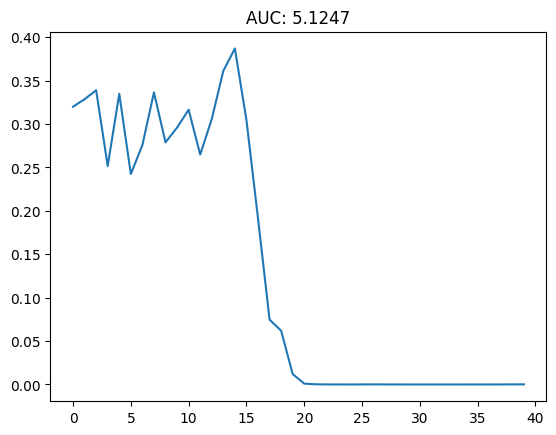

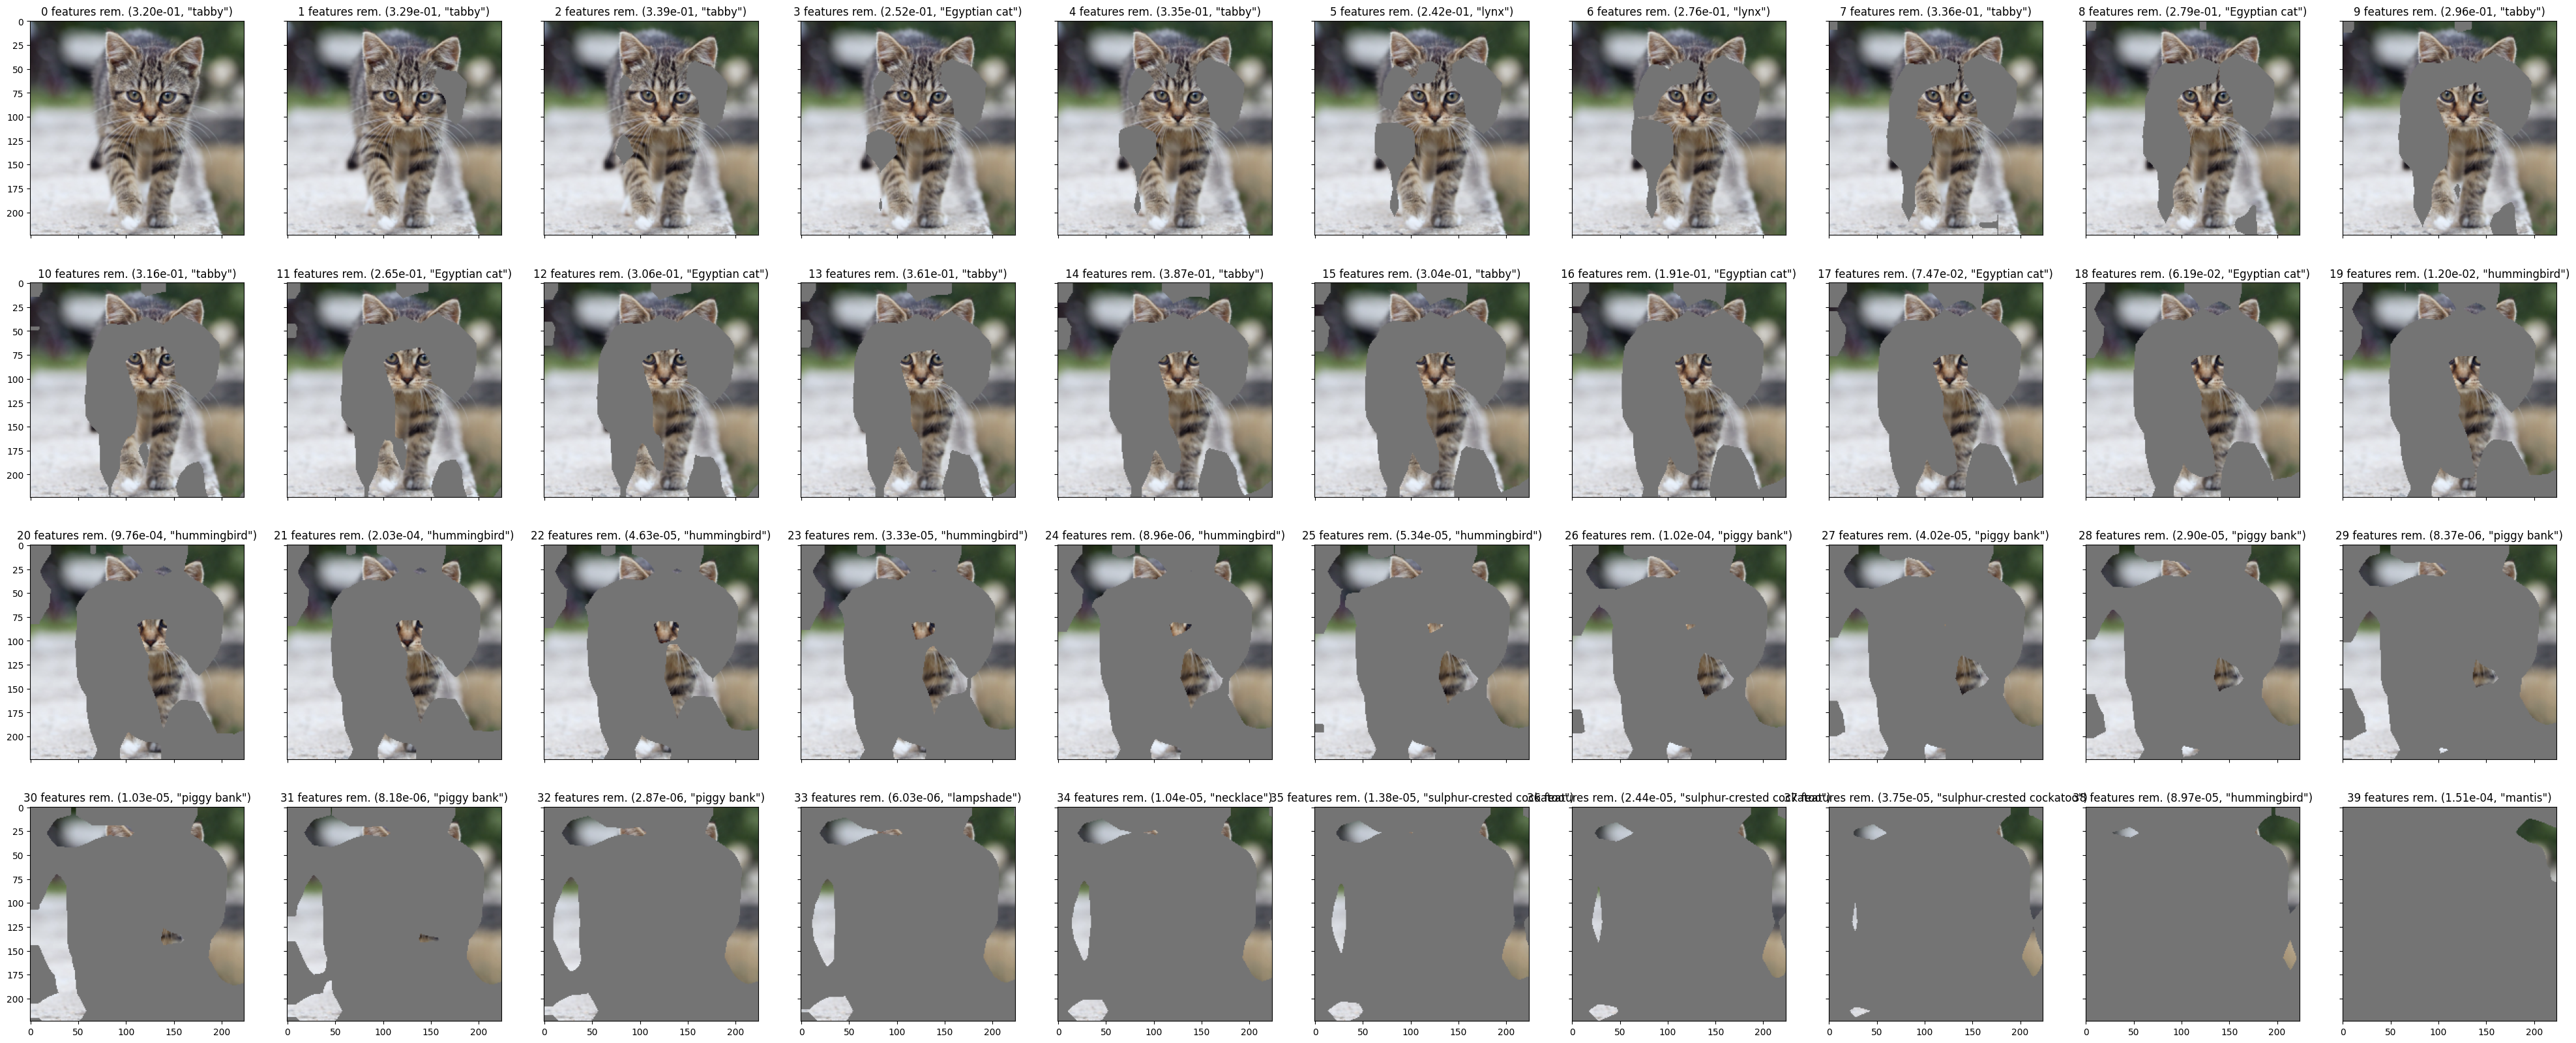

Predicted labels after each step:  ['tabby', 'tabby', 'tabby', 'Egyptian cat', 'tabby', 'lynx', 'lynx', 'tabby', 'Egyptian cat', 'tabby', 'tabby', 'Egyptian cat', 'Egyptian cat', 'tabby', 'tabby', 'tabby', 'Egyptian cat', 'Egyptian cat', 'Egyptian cat', 'hummingbird', 'hummingbird', 'hummingbird', 'hummingbird', 'hummingbird', 'hummingbird', 'hummingbird', 'piggy bank', 'piggy bank', 'piggy bank', 'piggy bank', 'piggy bank', 'piggy bank', 'piggy bank', 'lampshade', 'necklace', 'sulphur-crested cockatoo', 'sulphur-crested cockatoo', 'sulphur-crested cockatoo', 'hummingbird', 'mantis']


In [8]:
## COLLECT the results for a given image using GradCAM
## GradCAM, AlexNet on ImageNet

## Model & explainer
weights = models.AlexNet_Weights.DEFAULT
model: torch.nn.Module = models.alexnet(weights=weights).eval()
data_preproc = weights.transforms() ## model-specific data preprocessing function
categories = weights.meta["categories"] ## names of output classes; here: ImageNet classes
my_model = my_model_from(model)
gradcam_layer = model.features[10] ## Adjust to the correct layer in your model
print(f"DEBUG {gradcam_layer=}, {type(gradcam_layer)=}")
gradcam_explainer = LayerGradCam(model, gradcam_layer)
my_gradcam_explainer = my_explainer_from(gradcam_explainer)

## Get image
img: TVTensor = tv.io.read_image("kitten.jpg")
preproc_img: TVTensor = data_preproc(img).unsqueeze(0)

## Get results
results_gradcam = collect_class_predictions_under_masking(preproc_img, my_model=my_model, my_explainer=my_gradcam_explainer)

auc = calc_auc(results_gradcam, plot=True)
print("AUC: ", auc)

plot_results(results_gradcam, categories=categories)
print("Predicted labels after each step: ", [categories[best_cls_id] for best_cls_id in results_gradcam["best_classes"]]) ## when did the cat cease to be cat-like?

/Users/gesina/Postdoc/Nextcloud/teaching/2024-seminar-xai/explanation-selectivity/.venv/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


AUC:  0.1750732809305191


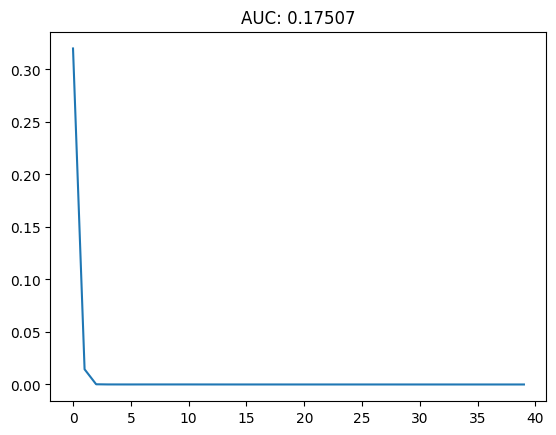

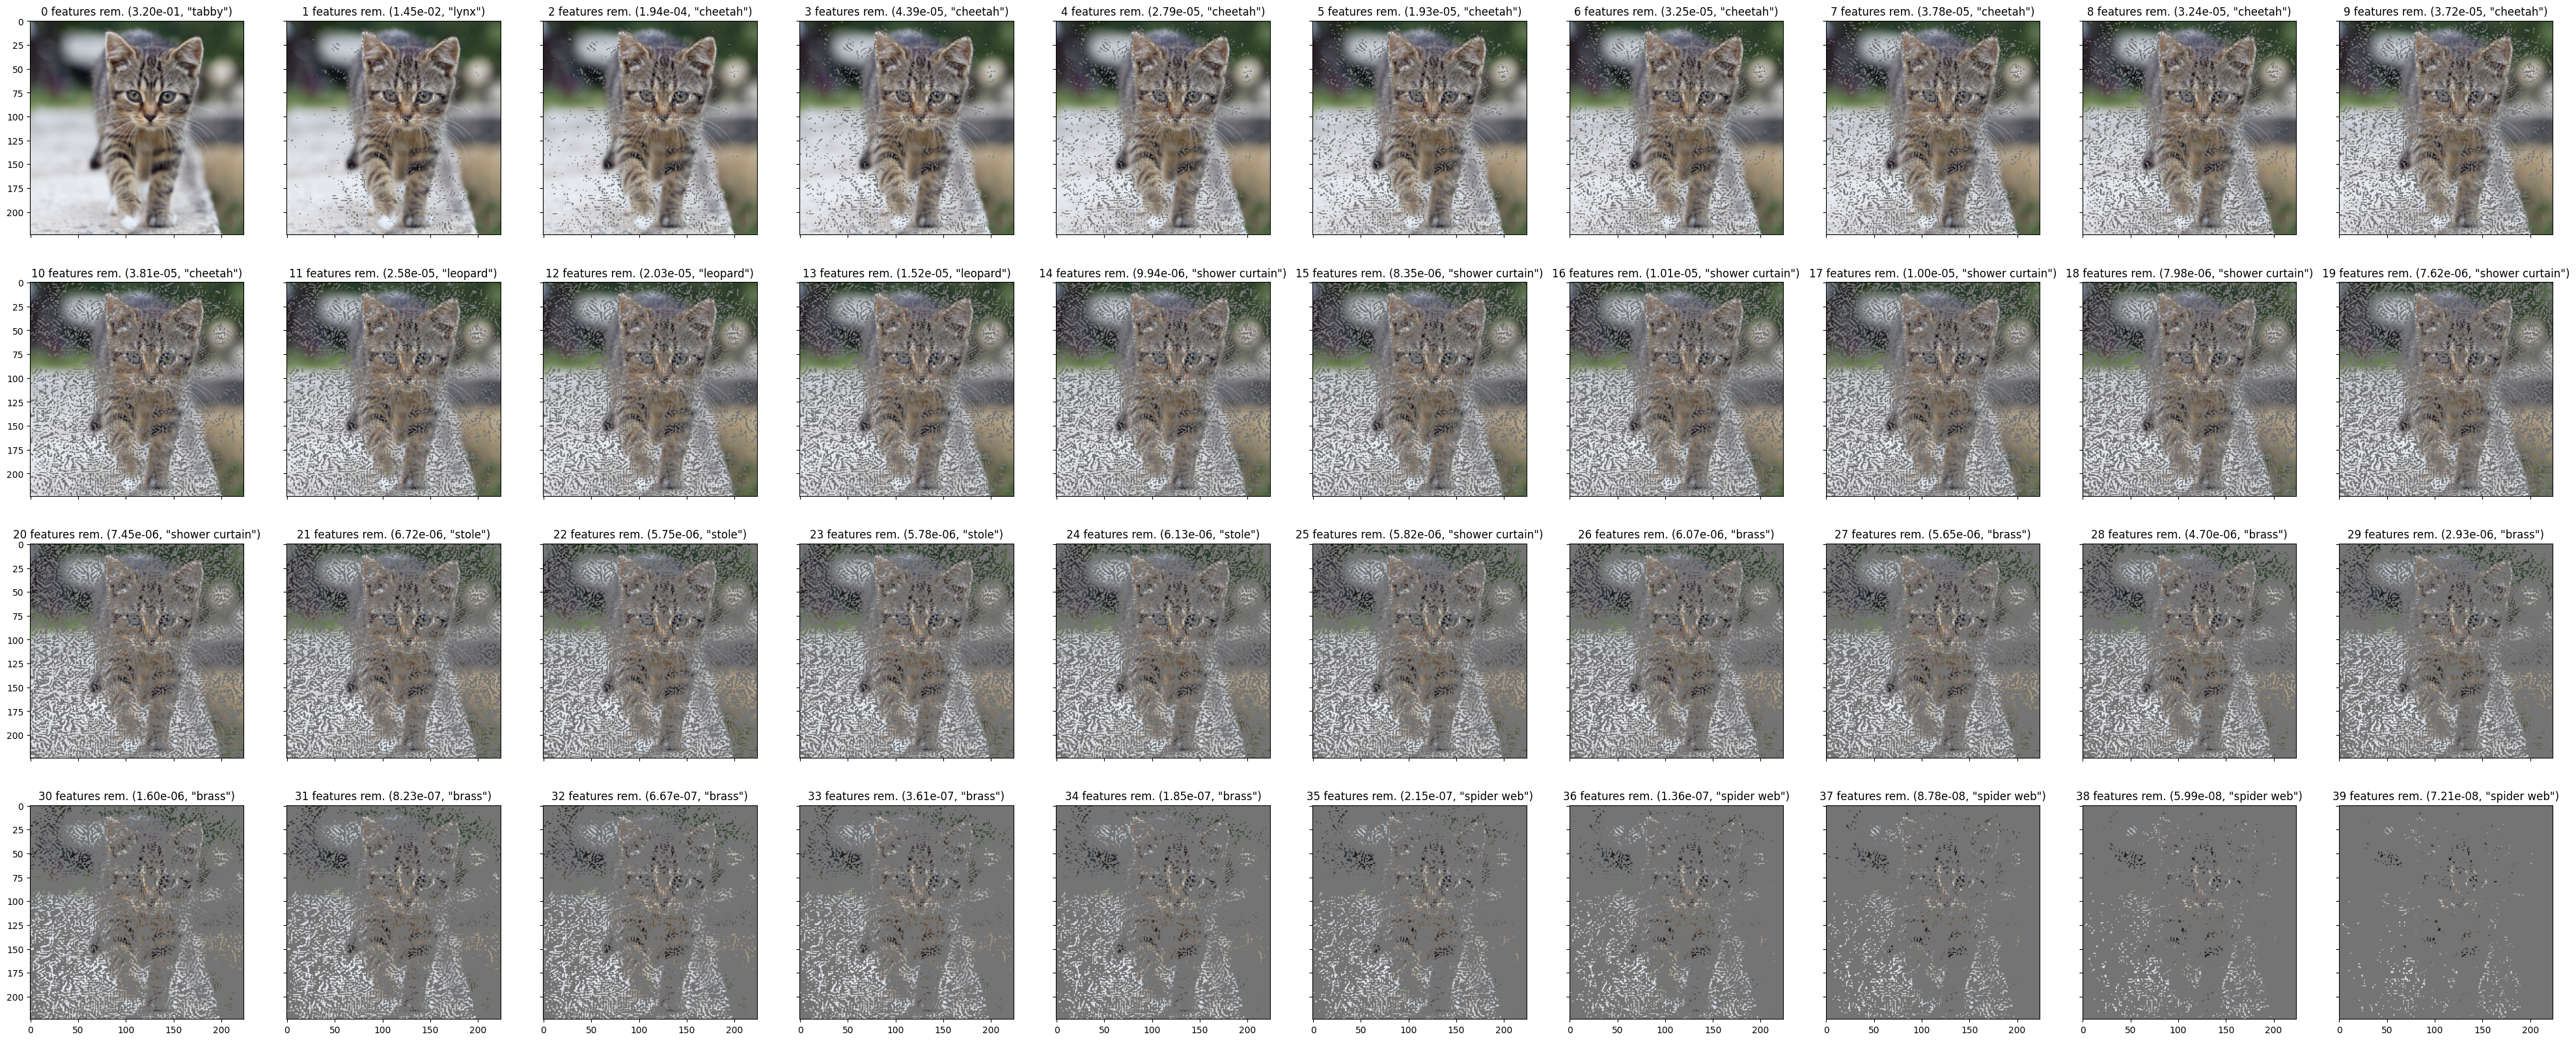

Predicted labels after each step:  ['tabby', 'tabby', 'tabby', 'Egyptian cat', 'tabby', 'lynx', 'lynx', 'tabby', 'Egyptian cat', 'tabby', 'tabby', 'Egyptian cat', 'Egyptian cat', 'tabby', 'tabby', 'tabby', 'Egyptian cat', 'Egyptian cat', 'Egyptian cat', 'hummingbird', 'hummingbird', 'hummingbird', 'hummingbird', 'hummingbird', 'hummingbird', 'hummingbird', 'piggy bank', 'piggy bank', 'piggy bank', 'piggy bank', 'piggy bank', 'piggy bank', 'piggy bank', 'lampshade', 'necklace', 'sulphur-crested cockatoo', 'sulphur-crested cockatoo', 'sulphur-crested cockatoo', 'hummingbird', 'mantis']


In [9]:
## COLLECT the results for a given image
## LRP, AlexNet on ImageNet

## Model & explainer
weights = models.AlexNet_Weights.DEFAULT
model: torch.nn.Module = models.alexnet(weights=weights).eval()
data_preproc = weights.transforms() ## model-specific data preprocessing function
categories = weights.meta["categories"] ## names of output classes; here: ImageNet classes
my_model = my_model_from(model)
my_explainer = my_explainer_from(LRP(model))

## Get image
img: TVTensor = tv.io.read_image("kitten.jpg")
preproc_img: TVTensor = data_preproc(img).unsqueeze(0)

## Get results
results = collect_class_predictions_under_masking(preproc_img, my_model=my_model, my_explainer=my_explainer)

auc = calc_auc(results, plot=True)
print("AUC: ", auc)

plot_results(results, categories=categories)
print("Predicted labels after each step: ", [categories[best_cls_id] for best_cls_id in results_gradcam["best_classes"]]) ## when did the cat cease to be cat-like?

AUC:  2.608954429626465


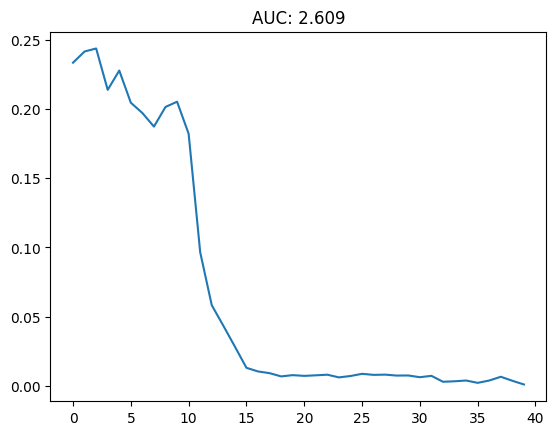

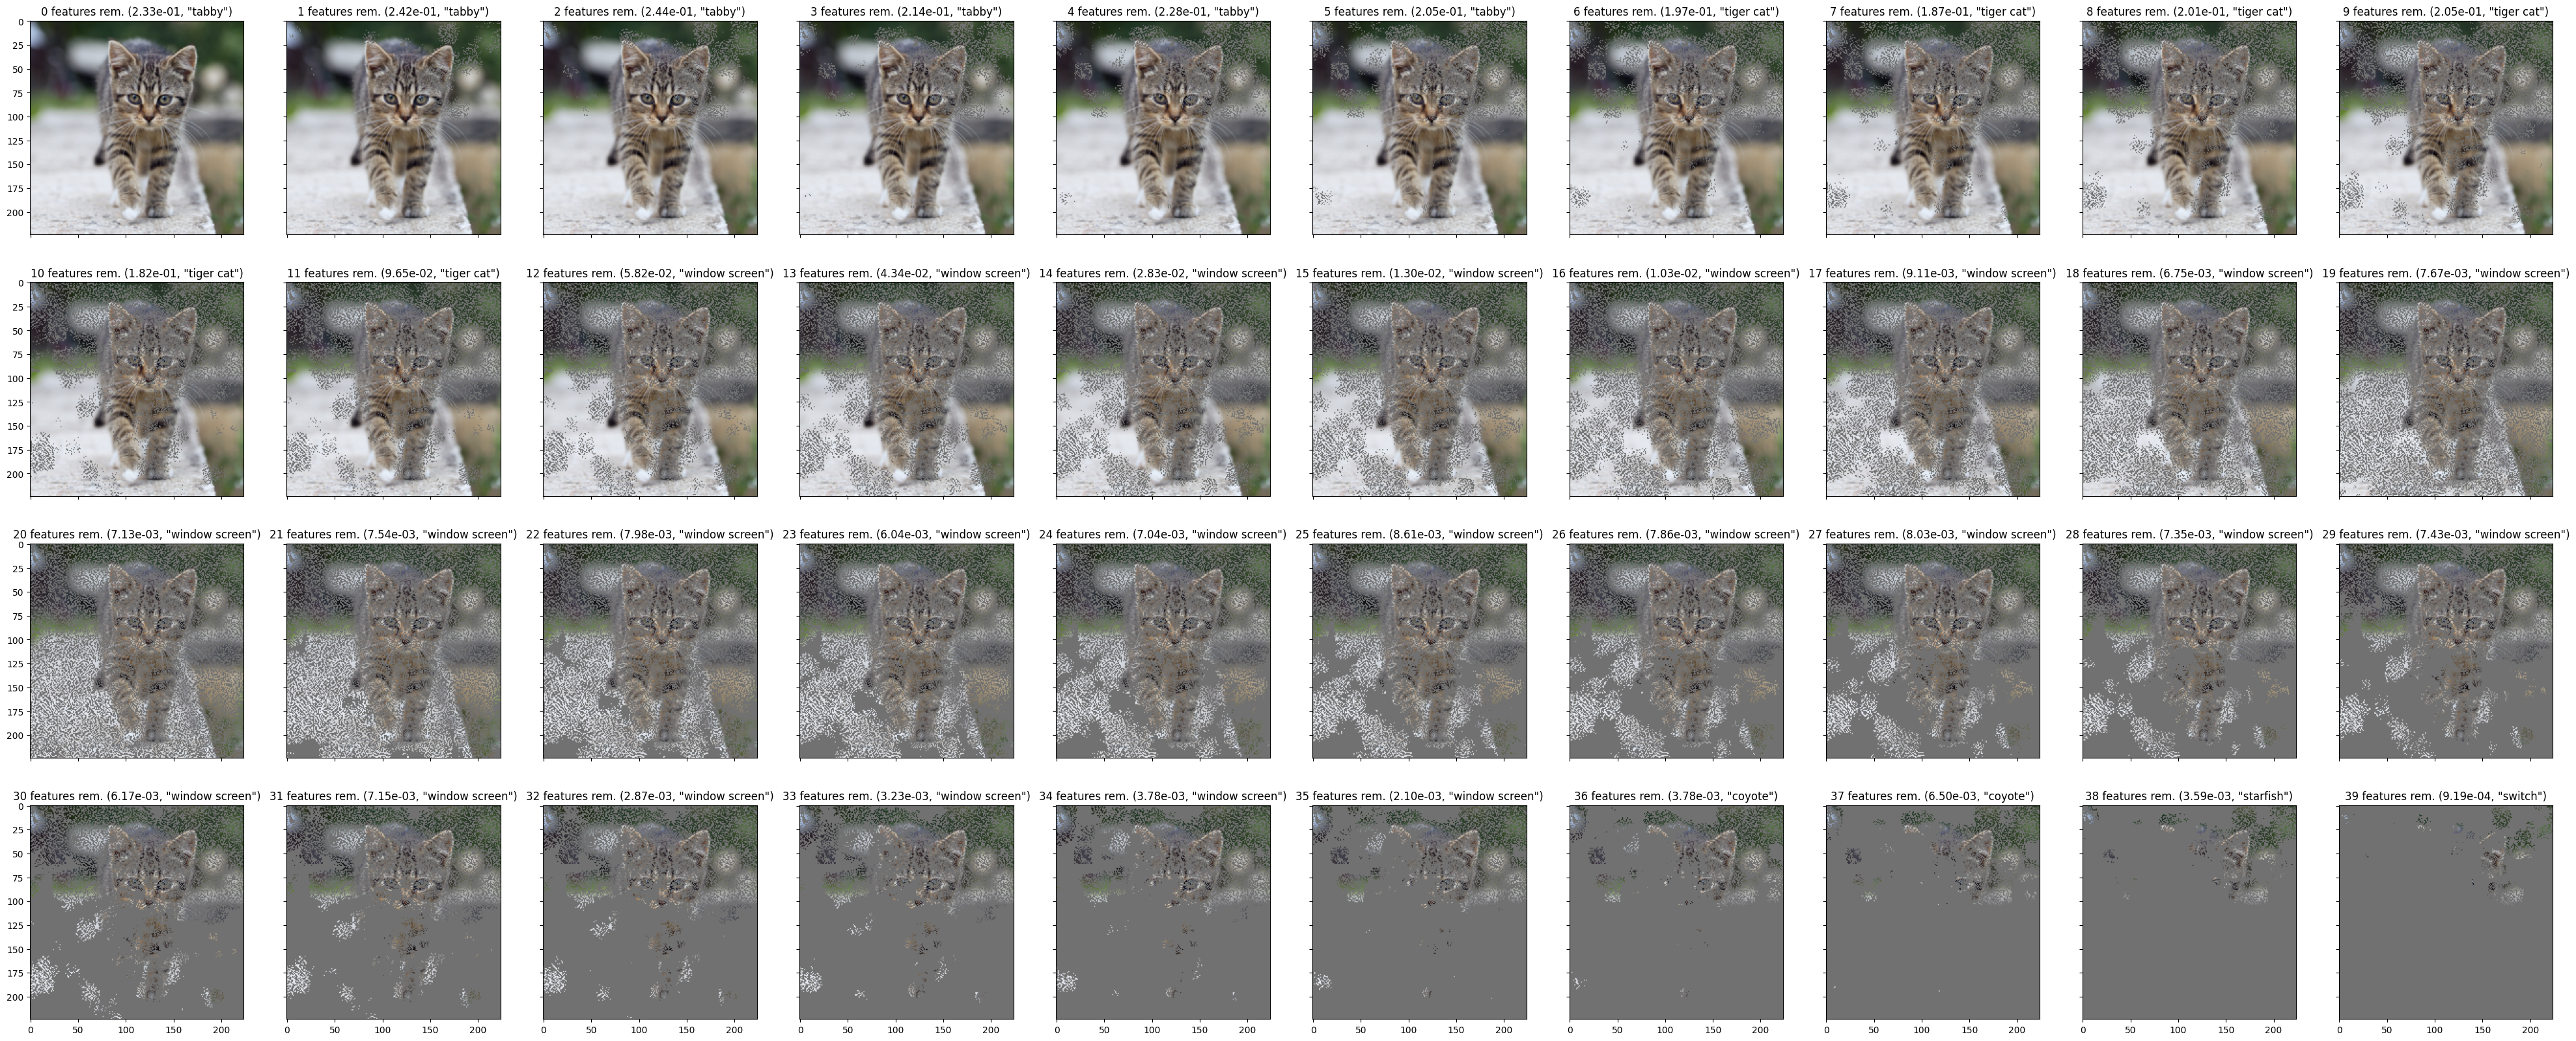

Predicted labels after each step:  ['tabby', 'tabby', 'tabby', 'Egyptian cat', 'tabby', 'lynx', 'lynx', 'tabby', 'Egyptian cat', 'tabby', 'tabby', 'Egyptian cat', 'Egyptian cat', 'tabby', 'tabby', 'tabby', 'Egyptian cat', 'Egyptian cat', 'Egyptian cat', 'hummingbird', 'hummingbird', 'hummingbird', 'hummingbird', 'hummingbird', 'hummingbird', 'hummingbird', 'piggy bank', 'piggy bank', 'piggy bank', 'piggy bank', 'piggy bank', 'piggy bank', 'piggy bank', 'lampshade', 'necklace', 'sulphur-crested cockatoo', 'sulphur-crested cockatoo', 'sulphur-crested cockatoo', 'hummingbird', 'mantis']


In [10]:
## COLLECT the results for a given image
## LRP, ResNet50 on ImageNet

## Model & Explainer
weights = models.ResNet50_Weights.DEFAULT
model: torch.nn.Module = models.resnet50(weights=weights).eval()
data_preproc = weights.transforms() ## model-specific data preprocessing function
categories = weights.meta["categories"] ## names of output classes; here: ImageNet classes
my_model = my_model_from(model)
my_explainer = my_explainer_from(LRP(model))

## Get image
img: TVTensor = tv.io.read_image("kitten.jpg")
preproc_img: TVTensor = data_preproc(img).unsqueeze(0)

## Get results
results = collect_class_predictions_under_masking(preproc_img, my_model=my_model, my_explainer=my_explainer)

auc = calc_auc(results, plot=True)
print("AUC: ", auc)

plot_results(results, categories=categories)
print("Predicted labels after each step: ", [categories[best_cls_id] for best_cls_id in results_gradcam["best_classes"]]) ## when did the cat cease to be cat-like?

AUC:  1.9708911180496216


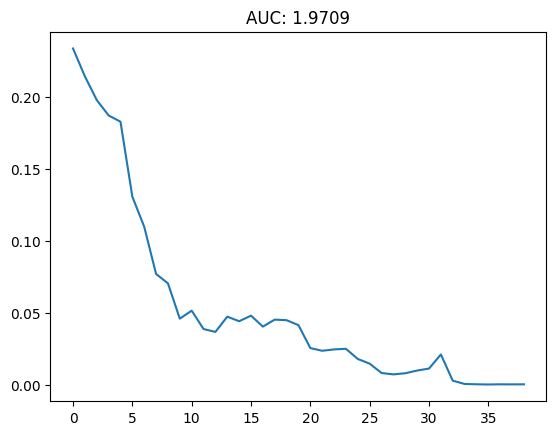

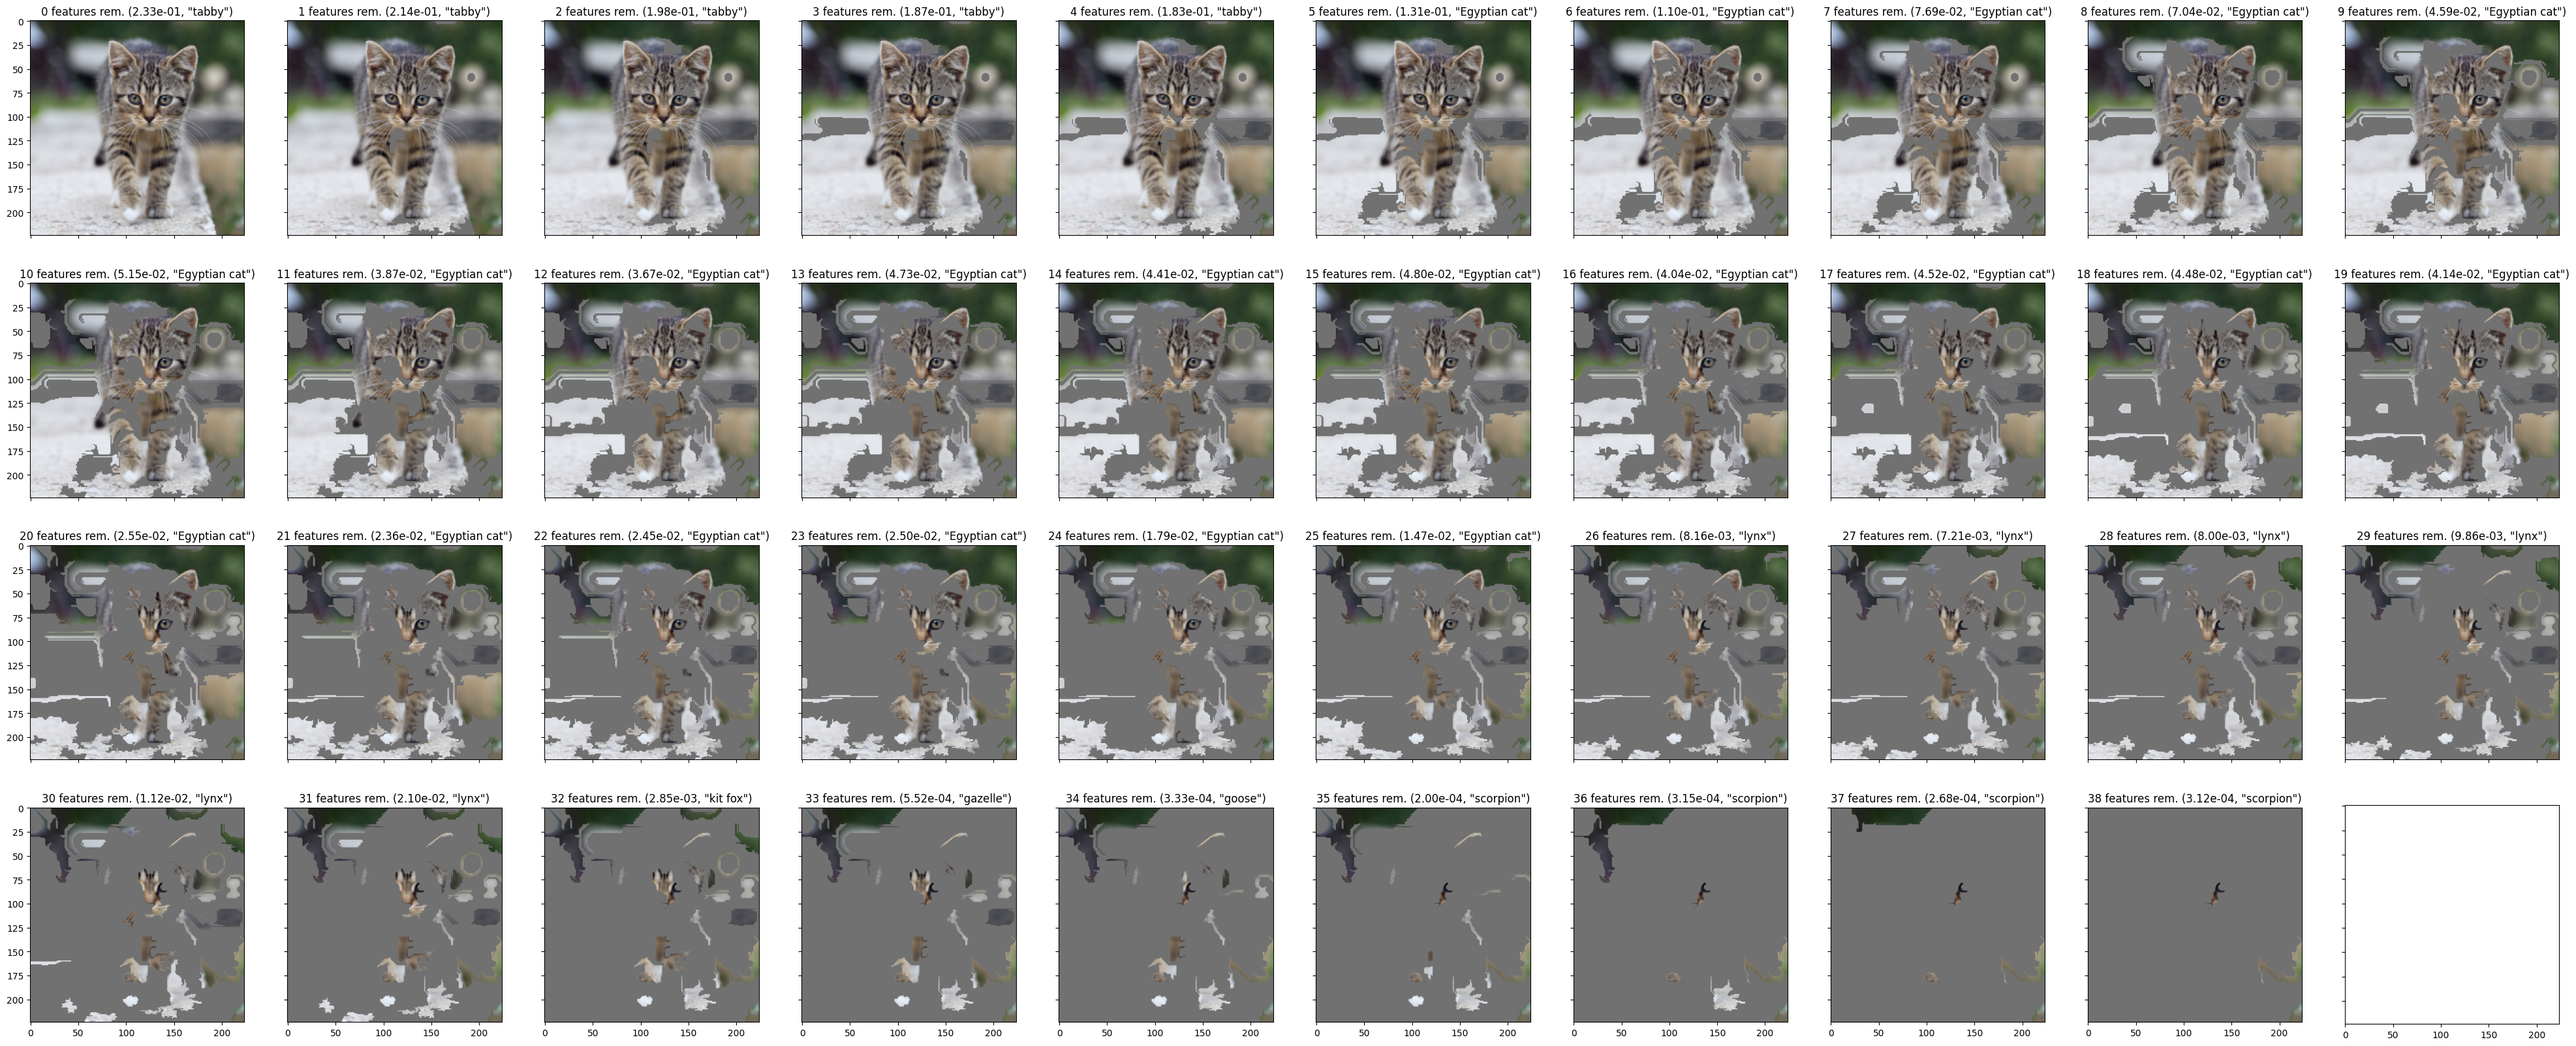

Predicted labels after each step:  ['tabby', 'tabby', 'tabby', 'Egyptian cat', 'tabby', 'lynx', 'lynx', 'tabby', 'Egyptian cat', 'tabby', 'tabby', 'Egyptian cat', 'Egyptian cat', 'tabby', 'tabby', 'tabby', 'Egyptian cat', 'Egyptian cat', 'Egyptian cat', 'hummingbird', 'hummingbird', 'hummingbird', 'hummingbird', 'hummingbird', 'hummingbird', 'hummingbird', 'piggy bank', 'piggy bank', 'piggy bank', 'piggy bank', 'piggy bank', 'piggy bank', 'piggy bank', 'lampshade', 'necklace', 'sulphur-crested cockatoo', 'sulphur-crested cockatoo', 'sulphur-crested cockatoo', 'hummingbird', 'mantis']


In [11]:
## COLLECT the results for a given image
## LIME, ResNet50 on ImageNet

## Model & Explainer
weights = models.ResNet50_Weights.DEFAULT
model: torch.nn.Module = models.resnet50(weights=weights).eval()
data_preproc = weights.transforms() ## model-specific data preprocessing function
categories = weights.meta["categories"] ## names of output classes; here: ImageNet classes
my_model = my_model_from(model)

def to_feature_mask_lime(preproc_img: TVTensor):
    """Create superpixels using the Felsenszwalb superpixeling algorithm.
    For alternative superpixeling algos see https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_segmentations.html"""
    segments_fz_np = felzenszwalb(to_plottable(preproc_img), scale=100, sigma=0.5, min_size=50)
    segments = torch.tensor(segments_fz_np).broadcast_to(3, *segments_fz_np.shape).unsqueeze(0)
    return segments

my_explainer = my_explainer_from(Lime(model, SkLearnLinearModel("linear_model.Ridge")), to_feature_mask=to_feature_mask_lime)

## Get image
img: TVTensor = tv.io.read_image("kitten.jpg")
preproc_img: TVTensor = data_preproc(img).unsqueeze(0)

## Get results
results = collect_class_predictions_under_masking(preproc_img, my_model=my_model, my_explainer=my_explainer)#, feature_mask=segments)

auc = calc_auc(results, plot=True)
print("AUC: ", auc)

plot_results(results, categories=categories)
print("Predicted labels after each step: ", [categories[best_cls_id] for best_cls_id in results_gradcam["best_classes"]]) ## when did the cat cease to be cat-like?

In [ ]:
model_infos = {
    "AlexNet": dict(
        weights = models.AlexNet_Weights.DEFAULT,
        model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT).eval(),
    ),
    "ResNet50": dict(
        weights = models.ResNet50_Weights.DEFAULT,
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT).eval()
    )
}
model_infos["AlexNet"]["gradcam_layer"] = model_infos["AlexNet"]["model"].features[10]
model_infos["ResNet50"]["gradcam_layer"] = model_infos["ResNet50"]["model"].layer4

explainer_builders = dict(
    lime=lambda model, **__: my_explainer_from(Lime(model, SkLearnLinearModel("linear_model.Ridge")), to_feature_mask=to_feature_mask_lime),
    lrp =lambda model, **__: my_explainer_from(LRP(model)),
    gradcam = lambda model, gradcam_layer, **__: my_explainer_from(LayerGradCam(model, gradcam_layer))
)

images: Iterable[TVTensor] = [tv.io.read_image("kitten.jpg")]


drop_masks = True

overall_results = []
for run in range(10):
    for model_name, model_info in model_infos.items():
        model, weights = model_info["model"], model_info["weights"]
        data_preproc = weights.transforms() ## model-specific data preprocessing function
        categories = weights.meta["categories"] ## names of output classes; here: ImageNet classes
        my_model = my_model_from(model)

        for explainer_name, explainer_builder in explainer_builders.items():
            my_explainer = explainer_builder(**model_info)
            
            for img_id, img in enumerate(images):
                preproc_img: TVTensor = data_preproc(img).unsqueeze(0)

                ## Get results
                cur_results = collect_class_predictions_under_masking(preproc_img, my_model=my_model, my_explainer=my_explainer)
                if drop_masks:
                    cur_results.pop("masked_imgs")
                auc = calc_auc(cur_results)

                overall_results.append(dict(
                    run=run,
                    img_id=img_id,
                    model=model_name,
                    explainer=explainer_name,
                    AUC=auc,
                    per_img_results=cur_results,
                ))


In [13]:
!pip install pandas
import pandas as pd

In [14]:
df = pd.DataFrame(overall_results)
df

run  img_id     model explainer       AUC  \
0     0       0   AlexNet      lime  2.302584   
1     0       0   AlexNet       lrp  0.175073   
2     0       0   AlexNet   gradcam  5.124665   
3     0       0  ResNet50      lime  2.020937   
4     0       0  ResNet50       lrp  2.608954   
5     0       0  ResNet50   gradcam  4.799583   
6     1       0   AlexNet      lime  1.184754   
7     1       0   AlexNet       lrp  0.175073   
8     1       0   AlexNet   gradcam  5.124665   
9     1       0  ResNet50      lime  2.971032   
10    1       0  ResNet50       lrp  2.608954   
11    1       0  ResNet50   gradcam  4.799583   
12    2       0   AlexNet      lime  1.161767   
13    2       0   AlexNet       lrp  0.175073   
14    2       0   AlexNet   gradcam  5.124665   
15    2       0  ResNet50      lime  2.131394   
16    2       0  ResNet50       lrp  2.608954   
17    2       0  ResNet50   gradcam  4.799583   
18    3       0   AlexNet      lime  1.365531   
19    3       0   AlexNet       lrp  0.175073   
20    3       0   AlexNet   gradcam  5.124665   
21    3       0  ResNet50      lime  1.568328   
22    3       0  ResNet50       lrp  2.608954   
23    3       0  ResNet50   gradcam  4.799583   
24    4       0   AlexNet      lime  2.364850   
25    4       0   AlexNet       lrp  0.175073   
26    4       0   AlexNet   gradcam  5.124665   
27    4       0  ResNet50      lime  2.009002   
28    4       0  ResNet50       lrp  2.608954   
29    4       0  ResNet50   gradcam  4.799583   
30    5       0   AlexNet      lime  1.527082   
31    5       0   AlexNet       lrp  0.175073   
32    5       0   AlexNet   gradcam  5.124665   
33    5       0  ResNet50      lime  2.554954   
34    5       0  ResNet50       lrp  2.608954   
35    5       0  ResNet50   gradcam  4.799583   
36    6       0   AlexNet      lime  1.997618   
37    6       0   AlexNet       lrp  0.175073   
38    6       0   AlexNet   gradcam  5.124665   
39    6       0  ResNet50      lime  2.026423   
40    6       0  ResNet50       lrp  2.608954   
41    6       0  ResNet50   gradcam  4.799583   
42    7       0   AlexNet      lime  2.379568   
43    7       0   AlexNet       lrp  0.175073   
44    7       0   AlexNet   gradcam  5.124665   
45    7       0  ResNet50      lime  2.646293   
46    7       0  ResNet50       lrp  2.608954   
47    7       0  ResNet50   gradcam  4.799583   
48    8       0   AlexNet      lime  1.090347   
49    8       0   AlexNet       lrp  0.175073   
50    8       0   AlexNet   gradcam  5.124665   
51    8       0  ResNet50      lime  2.675455   
52    8       0  ResNet50       lrp  2.608954   
53    8       0  ResNet50   gradcam  4.799583   
54    9       0   AlexNet      lime  2.879080   
55    9       0   AlexNet       lrp  0.175073   
56    9       0   AlexNet   gradcam  5.124665   
57    9       0  ResNet50      lime  3.267578   
58    9       0  ResNet50       lrp  2.608954   
59    9       0  ResNet50   gradcam  4.799583   

                                      per_img_results  
0   {'predictions': ([1.6137088193479698e-11, 3.96...  
1   {'predictions': ([1.6137088193479698e-11, 3.96...  
2   {'predictions': ([1.6137088193479698e-11, 3.96...  
3   {'predictions': ([0.0005362401134334505, 0.000...  
4   {'predictions': ([0.0005362401134334505, 0.000...  
5   {'predictions': ([0.0005362401134334505, 0.000...  
6   {'predictions': ([1.6137088193479698e-11, 3.96...  
7   {'predictions': ([1.6137088193479698e-11, 3.96...  
8   {'predictions': ([1.6137088193479698e-11, 3.96...  
9   {'predictions': ([0.0005362401134334505, 0.000...  
10  {'predictions': ([0.0005362401134334505, 0.000...  
11  {'predictions': ([0.0005362401134334505, 0.000...  
12  {'predictions': ([1.6137088193479698e-11, 3.96...  
13  {'predictions': ([1.6137088193479698e-11, 3.96...  
14  {'predictions': ([1.6137088193479698e-11, 3.96...  
15  {'predictions': ([0.0005362401134334505, 0.000...  
16  {'predictions': ([0.0005362401134334505, 0.000...  
17  {'

<Axes: xlabel='model,explainer'>

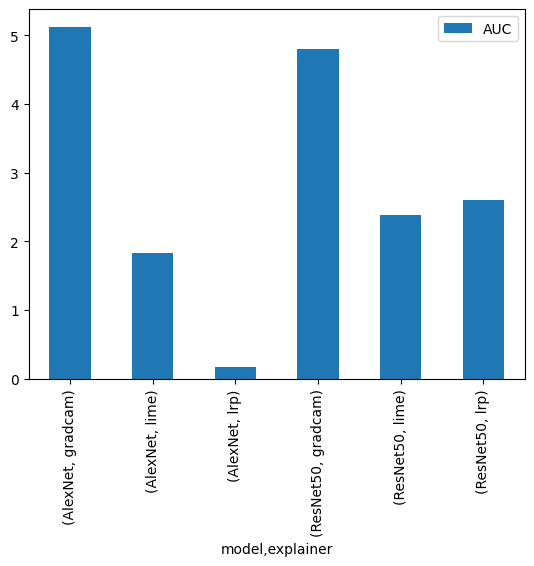

In [15]:
groups = df[["explainer", "model", "AUC"]].groupby(["model", "explainer"])
groups.mean().plot.bar()